# 変数定義

4 seasons * 7 bandsのデータ

In [1]:
# define vars ---------------------------------------------
under = 90
gpu_list = ['/gpu:0', '/gpu:1']
SEED = 31
DEM = True

# 共通params ---------------------------------------------------
n_trials  = 2**5          # ベイズ最適化回数
outer_cvs = 10
inner_cvs = 10

# CNN Training params ------------------------------------------
train_epochs = 2**5      # エポック数
best_epochs = 2**5       # 最終モデル決定用のエポック数
early_stopping = 2**3    # 

# LightGBM params -----------------------------------------------
lgb_boosting_type = 'gbdt'

import os, zipfile, io, re
os.environ["OMP_NUM_THREADS"] = "6"

# Init

In [2]:
# imports
# Utils -----------------------
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import random
import pickle
import datetime
import gc
from tqdm import tqdm
import warnings
import seaborn as sns
from glob import glob
import ipynb_path
from math import sqrt
import tifffile
# Machine Learning ---------------
import lightgbm as LGB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from optuna import integration
import optuna
import optuna.integration.lightgbm as lgb
# Keras, TensorFlow ---------------
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Convolution2D, Input
from keras import optimizers
from keras.utils import multi_gpu_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')
SEED = 31
np.random.seed(SEED)
gpus = len(gpu_list)

Using TensorFlow backend.


In [3]:
# define functions
def pkl_saver(object, pkl_filename):
    with open(pkl_filename, 'wb') as web:
        pickle.dump(object , web)

def pkl_loader(pkl_filename):
    with open(pkl_filename, 'rb') as web:
        data = pickle.load(web)
    return data

def dir_generator(dir_path):
    if os.path.exists(dir_path) == False:
        os.mkdir(dir_path)

def train_import():
    if os.path.exists(data_path + f'df_{N}x{N}.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}.pkl')
    else:
        trial = int(len(imgfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for imgfile in imgfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image)
            Y_28 = file_split[5].split(".")[0]
            point_28 = [float(file_split[1]), float(file_split[2])]
            filenames.append(f"{file_split[0]}_{file_split[1]}_{file_split[2]}_{Y_28}")
            X.append(X_28[box*28: (box+1)*28])
            Y.append(Y_28)
            point.append(point_28)
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
        X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}.pkl'))
        
    return df[0], df[1], df[2], df[3], df[4]
def train_transform():
    if os.path.exists(data_path + f'df_{N}x{N}_{standarization[standarization_num]}.pkl'):
        df_train = pkl_loader(data_path + f'df_{N}x{N}_{standarization[standarization_num]}.pkl')
        print("train_df をインポートしたよ！")
    else:
        print("pklを新しく作成中ですが，標準化・正規化のコードに書き直しましたか？")
        X_train_zeros = np.zeros((X_train.shape[0], N*N*28))
        for i in range(len(X_train)):
            for k in range(N):
                for l in range(N):
                    for j in range(28):
                        X_train_zeros[i][j+k+l] = X_train[i][k][l][j]
        # X_train の名前が重複していたので違う名前に変えた. X_train_tmp
        X_train_tmp = X_train_zeros
        df_train = pd.concat([make_df(Y_train), make_df(X_train_tmp)], axis=1)
        pkl_saver(df_train, os.path.join(data_path, f'df_{N}x{N}_{standarization[standarization_num]}.pkl'))
        
    return df_train.iloc[:, 1:], make_df(Y_train)
def train_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_dem.pkl')
    else:
        trial = int(len(imgfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for imgfile in imgfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)[0][0]
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image)
            dem_data = tifffile.imread(train_dem_files[box])[0][0]
            X_28.append(dem_data)
            Y_28 = file_split[5].split(".")[0]
            point_28 = [float(file_split[1]), float(file_split[2])]
            filenames.append(f"{file_split[0]}_{file_split[1]}_{file_split[2]}_{Y_28}")
            X.append(X_28[box*29: (box+1)*29])
            Y.append(Y_28)
            point.append(point_28)
    #         if box==100:break
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
    #     X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_dem.pkl'))
    
    return df[0], df[1], df[2], df[3], df[4]
def train_3x3_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_dem.pkl')
    else:
        trial = int(len(imgfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for imgfile in imgfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                for i in range(N):
                    for j in range(N):
                        X_28.append(image[i][j])
            dem_data = tifffile.imread(train_dem_files[box])
            for i in range(N):
                for j in range(N):
                    X_28.append(dem_data[i*3+1][j*3+1])
            Y_28 = file_split[5].split(".")[0]
            point_28 = [float(file_split[1]), float(file_split[2])]
            filenames.append(f"{file_split[0]}_{file_split[1]}_{file_split[2]}_{Y_28}")
            X.append(X_28[box*29*N*N: (box+1)*29*N*N])
            Y.append(Y_28)
            point.append(point_28)
#             if box==100:break

        del X_28, Y_28, point_28

        X = np.asarray(X)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_dem.pkl'))
    
    return df[0], df[1], df[2], df[3], df[4]
        
def test_import():
    if os.path.exists(data_path + f'df_{N}x{N}_testset.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_testset.pkl')
    else:
        trial = int(len(testfiles)/28)
    #     trial = 100
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for box in tqdm(range(trial)):
            for imgfile in testfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image)

            Y_28 = int(file_split[4].split(".")[0]) - 1
    #         print(file_split, Y_28)
            point_28 = [float(file_split[0]), float(file_split[1])]
            filenames.append(f"test_{file_split[0]}_{file_split[1]}_{labels[Y_28]}")
            X.append(X_28[box*28: (box+1)*28])
            Y.append(Y_28)
            point.append(point_28)
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
        X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_testset.pkl'))
        
    return df
def test_transform():
    if os.path.exists(data_path + f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl'):
        df_test = pkl_loader(data_path + f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl')
        print("test_df をインポートしたよ！")
    else:
        print("pklを新しく作成中ですが，標準化・正規化のコードに書き直しましたか？")
        X_test_zeros = np.zeros((X_test.shape[0], N*N*28))
        for i in range(len(X_test)):
            for k in range(N):
                for l in range(N):
                    for j in range(28):
                        X_test_zeros[i][j+k+l] = X_test[i][k][l][j]
        # X_test の名前が重複していたので違う名前に変えた. X_test_tmp
        X_test_tmp = X_test_zeros
        df_test = pd.concat([make_df(Y_test), make_df(X_test_tmp)], axis=1)
        pkl_saver(df_test, os.path.join(data_path, f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl'))
        
    return df_test.iloc[:, 1:], make_df(Y_test)
def test_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_test_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_test_dem.pkl')
    else:
        trial = int(len(testfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for testfile in testfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(testfile)
        #         print(image.shape)
                file = os.path.basename(testfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image[0][0])
            dem_data = tifffile.imread(test_dem_files[box])[0][0]
            X_28.append(dem_data)
            Y_28 = file_split[4].split(".")[0]
            point_28 = [float(file_split[0]), float(file_split[1])]
            filenames.append(f"{box}_{file_split[0]}_{file_split[1]}_{Y_28}")
            X.append(X_28[box*29: (box+1)*29])
            Y.append(Y_28)
            point.append(point_28)
    #         if box==100:break
        del X_28, Y_28, point_28
        X = np.asarray(X)
    #     X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_test_dem.pkl'))
        
    return df[0], df[1], df[2], df[3], df[4]
def test_3x3_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_test_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_test_dem.pkl')
    else:
        trial = int(len(testfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for testfile in testfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(testfile)
        #         print(image.shape)
                file = os.path.basename(testfile)
                file_split = [i for i in file.split('_')]
                for i in range(N):
                    for j in range(N):
                        X_28.append(image[i][j])
            dem_data = tifffile.imread(test_dem_files[box])
            for i in range(N):
                for j in range(N):
                    X_28.append(dem_data[i*3+1][j*3+1])
            Y_28 = file_split[4].split(".")[0]
            point_28 = [float(file_split[0]), float(file_split[1])]
            filenames.append(f"{box}_{file_split[0]}_{file_split[1]}_{Y_28}")
            X.append(X_28[box*29*N*N: (box+1)*29*N*N])
            Y.append(Y_28)
            point.append(point_28)
#             if box==100:break
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_test_dem.pkl'))
        
    return df[0], df[1], df[2], df[3], df[4]

def data_splitter_cv(filenames, X, Y, cv, region, point):
    test_index = np.where(region==cv)
    train_index = np.setdiff1d(np.arange(0, X.shape[0], 1), test_index)
    train_files = filenames[train_index]
    test_files = filenames[test_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    X_train = X[train_index]
    Y_train = Y[train_index]
    train_region = region[train_index]
    train_point = point[train_index]
    return train_files, test_files, X_train, X_test, Y_train, Y_test, train_region, train_point

# Loss Definition ----------------------------------
def opt_cnn(trial):
    # Opt params -----------------------
    # Categorical parameter
    num_layer = trial.suggest_int('num_layer', 1, 2)
    dense_num = trial.suggest_int('dense_num', 3, 7)
    num_filters = [int(trial.suggest_discrete_uniform(f'num_filter_{i}', 7, 10, 1)) for i in range(num_layer)]
    size_filters = [int(trial.suggest_discrete_uniform(f'size_filter_{i}', 3, 3, 1)) for i in range(num_layer)]
    batch_size = trial.suggest_int('batch_size', 1, 5)
    # Model Compiler -----------------------
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    decay = trial.suggest_loguniform('decay', 1e-6, 1e-3)
    # Discrete-uniform parameter
    dropout_rate_in = trial.suggest_discrete_uniform('dropout_rate_in', 0.0, 0.5, 0.1)
    dropout_rate_out = trial.suggest_discrete_uniform('dropout_rate_out', 0.0, 0.5, 0.1)
    momentum = trial.suggest_discrete_uniform('momentum', 0.0, 0.5, 0.1)
    # categorical parameter
#    optimizer = trial.suggest_categorical("optimizer", ["sgd", "momentum", "rmsprop", "adam"])
    padding = "same"
#     padding = trial.suggest_categorical('padding', ['same'])
    # compile model-------------------
#     from IPython.core.debugger import Pdb; Pdb().set_trace()
    model = create_model(image_shape, num_layer, padding, dense_num, num_filters, size_filters, dropout_rate_in, dropout_rate_out)
    sgd = optimizers.SGD(lr = lr, decay = decay, momentum = momentum, nesterov = True)
#    sgd = optimizers.SGD(lr = lr, decay = decay, momentum = momentum, nesterov = True, clipvalue = 1.0)
    # For CPU run ------------------
    model.compile(optimizer = sgd, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    # Train Model ----------------------------------
    es_cb = EarlyStopping(monitor = 'val_loss', patience = early_stopping, verbose = 0)
    pr_cb = integration.TFKerasPruningCallback(trial, 'val_loss')
    cbs = [es_cb, pr_cb]
    loss_list, acc_list = [], []
    for inner_cv in range(0, inner_cvs):
        print("outer_cv =", outer_cv, "    inner_cv = ", inner_cv)
        _, _, X_inner_train, X_inner_val, Y_inner_train, Y_inner_val, _, _ = data_splitter_cv(train_files, X_outer_train, Y_outer_train, inner_cv, val_train_region, val_train_point)
        hist = model.fit(
            train_datagen.flow(X_inner_train, Y_inner_train, batch_size = (2**batch_size) * gpus),
            epochs = train_epochs,
            validation_data = (X_inner_val, Y_inner_val),
            callbacks = cbs,
            shuffle = True,
            verbose = 0,
            use_multiprocessing = False)
        loss_list += [model.evaluate(X_inner_val, Y_inner_val)[0]]
        acc_list += [model.evaluate(X_inner_val, Y_inner_val)[1]]
    del model
    keras.backend.clear_session()
    gc.collect()
    eval_loss = np.mean(loss_list)
    eval_acc = np.mean(acc_list)
    print("eval_acc = ", eval_acc)
    return eval_loss

def create_model(image_shape, num_layer, padding, dense_num, num_filters, size_filters, dropout_rate_in, dropout_rate_out):
    inputs = Input(image_shape)
    for d in gpu_list:
        with tf.device(d):
            x = Dropout(dropout_rate_in)(inputs)
            x = Convolution2D(filters = 2**num_filters[0], kernel_size = (size_filters[0],size_filters[0]), padding = "same", activation = 'relu')(x)
            for i in range(1, num_layer):
                x = Convolution2D(filters = 2**num_filters[i],
                                  kernel_size = (size_filters[i], size_filters[i]),
                                  padding = padding,
                                  activation = 'relu')(x)
            x = GlobalAveragePooling2D()(x)
            x = Dropout(dropout_rate_out)(x)
            x = Dense(units = 2**dense_num, activation = 'relu')(x)
            x = Dense(units = num_category, activation = 'softmax')(x)
            model = Model(inputs = inputs, outputs = x)
    return model

def mean_params_calc(param_names):
    dict = {}
    categoricals = ['padding']
    for param_name in param_names:
        data_num = 0
        if param_name not in categoricals:
            for data in best_params:
                try:
                    try:
                        dict[param_name] += data[param_name]
                    except:
                        dict[param_name] = data[param_name]
                    data_num = data_num + 1
                except:
                    pass
            dict[param_name] = dict[param_name]/data_num
        else:
            categorical_list = []
            for data in best_params:
                try:
                    categorical_list = categorical_list + [data[param_name]]
                except:
                    pass
            dict[param_name] = stats.mode(categorical_list)[0][0]
    return dict

def cv_result_imgs_generator(model, history):
    # Visualize Loss Results ----------------------------
    plt.figure(figsize=(18,6))
    plt.plot(history.history["loss"], label="loss", marker="o")
    plt.plot(history.history["val_loss"], label="val_loss", marker="o")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("")
    plt.legend(loc="best")
    plt.grid(color='gray', alpha=0.2)
    plt.savefig('./img_loss/' + str(outer_cv) + '_loss.jpg')
    plt.close()

def region_image_generator(point, region):
    data_num = int(len(imgfiles)/28)
    cmap = plt.get_cmap("tab10")
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(point[:data_num][:,0],point[:data_num][:,1], marker='o', s=5, color=cmap(region))
    ax.set_title("Region in Japan")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_xlim([120, 155])
    ax.set_ylim([20, 50])
    fig.savefig('./region_separate.png')

def make_dirs(model_name):
    base_path = os.path.join(result_path , model_name)
    # dir generation
    dir_generator(base_path)
    # Chenge current directry
    os.mkdir(os.path.join(base_path, timename))
    os.chdir(os.path.join(base_path, timename))
    dir_generator(model_path)
    dir_generator("./results/")
    dir_generator("./img_loss/")
    dir_generator("./model/")
    dir_generator("./weights/")
    dir_generator("./logs/")
    dir_generator("./outer_cv_times/")

def time_printer(start_time):
    end_time = datetime.datetime.now()
    spend_time = f"Outer_cv time is {end_time - start_time} seconds."
    
# LightGBM ----------------------------------------------------
# -------------------------------------------------------------
def opt_lgb(trial):
    if lgb_boosting_type == "gbdt":
        param_grid_lgb = {
    #         "device": "gpu",
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 15),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    elif lgb_boosting_type =="rf":
        param_grid_lgb = {
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 15),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    
    os.makedirs(f"./results/outer_{outer_cv}", exist_ok=True)
    scores = []
    for inner_cv in range(inner_cvs):
        _, _, X_inner_train, X_inner_val, Y_inner_train, Y_inner_val, _, _ = lgb_splitter_cv(train_files, X_outer_train, Y_outer_train, outer_cv, val_train_region, val_train_point)

        model = LGBMClassifier(**param_grid_lgb)
        model.fit(X_inner_train, Y_inner_train)
        
        scores.append(model.score(X_inner_val, Y_inner_val))
        
        # DEBUG -------------------------------------------------
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        inner_metr = make_df(confusion_matrix(Y_inner_val.astype(int).values, model.predict(X_inner_val).astype(int)))
        inner_metr.to_csv(f"./results/outer_{outer_cv}/inner_{inner_cv}_acc{round(model.score(X_inner_val, Y_inner_val), 2)}.csv")
    
#     print('mean of inner_val_scores is ', np.mean(scores))
    return np.mean(scores)
def opt_lgb_random(trial):
    if lgb_boosting_type == "gbdt":
        param_grid_lgb = {
    #         "device": "gpu",
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 30),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    elif lgb_boosting_type =="rf":
        param_grid_lgb = {
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 30),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    
    os.makedirs(f"./results/outer_{outer_cv}", exist_ok=True)
    scores = []
    skf = StratifiedKFold(n_splits=inner_cvs, random_state=SEED, shuffle=False)
    inner_cv = 0
    X_valid  = X_outer_train
    Y_valid  = Y_outer_train
#     X_valid  = X_outer_train.values
#     Y_valid  = Y_outer_train.values
    for train_index, valid_index in skf.split(X_valid, Y_valid):
        # DEBUG -------------------------------------------------
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        
        X_inner_train, X_inner_val = X_outer_train[train_index], X_outer_train[valid_index]
        Y_inner_train, Y_inner_val = Y_outer_train[train_index], Y_outer_train[valid_index]
#         X_inner_train, X_inner_val = X_outer_train.to_numpy()[train_index], X_outer_train.to_numpy()[valid_index]
#         Y_inner_train, Y_inner_val = Y_outer_train.to_numpy()[train_index], Y_outer_train.to_numpy()[valid_index]

        model = LGBMClassifier(**param_grid_lgb)
        model.fit(X_inner_train, Y_inner_train)
        
        scores.append(model.score(X_inner_val, Y_inner_val))
        
        inner_cv += 1
#     print('mean of inner_val_scores is ', np.mean(scores))
    return np.mean(scores)

def lgb_splitter_cv(filenames, X, Y, cv, region, point):
#     from IPython.core.debugger import Pdb; Pdb().set_trace()
    test_index = np.where(region==cv)
    train_index = np.setdiff1d(np.arange(0, X.shape[0], 1), test_index)
    train_files = filenames[train_index]
    test_files = filenames[test_index]
    X_test = np.array(X)[test_index]
    Y_test = np.array(Y)[test_index]
    X_train = np.array(X)[train_index]
    Y_train = np.array(Y)[train_index]
    train_region = region[train_index]
    train_point = point[train_index]
    X_train, X_test, Y_train, Y_test = make_df(X_train), make_df(X_test), make_df(Y_train), make_df(Y_test)
    return train_files, test_files, X_train, X_test, Y_train, Y_test, train_region, train_point

def make_df(X):
    return pd.DataFrame(X)

# Model

## LightGBM (1x1 pixel)

In [7]:
# Data Loader ------------------------------------------------------------------------
# ================================== landsat8 Data Import ==================================
N = 1
if under==20:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_old/{N}x{N}"
elif under==90:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_new/{N}x{N}"

testfiles = glob(f"D:/LULC/features/01_landsat8/train_new/{N}x{N}_test" + "/*.tif")
testfiles.sort()

root_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/"
result_path    = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/{N}x{N}"
data_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/data/"
model_path     = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/model/{N}x{N}/"
imgfiles = glob(train_tif_name + "/*.tif")
imgfiles.sort()

# data import ---------------------------------------------------------------------------
timename       = '{0:%Y_%m%d_%H%M}'.format(datetime.datetime.now())
time_path      =  os.path.join(result_path, lgb_boosting_type, timename, "outer_cv_times")

train_path = os.path.join(data_path, f'df_1scene_lack_{N}x{N}_prcp_temp_dem.pkl')
test_path = os.path.join(data_path, f'df_1scene_lack_test_{N}x{N}_prcp_temp_dem.pkl')
if os.path.exists(train_path):
    X_files, X_landsat_train, Y_train, train_point, region_train = pkl_loader(train_path)
    Y_files, X_landsat_test, Y_test, test_point, region_test = pkl_loader(test_path)
else:
    # ------------train import----------------------
    X_files, X_train, Y_train, train_point, region_train = train_dem_import()
    # image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    num_category = len(np.unique(Y_train))
    X_train = X_train.astype(np.float64)
    Y_train = Y_train.astype(np.float64)
    # ------------test import----------------------
    Y_files, X_test, Y_test, test_point, region_test = test_dem_import()
    Y_test = Y_test.astype(np.int64) - 1
    # ==============================================================================================
    # ================================== New Data Import ===========================================
    train_prcp = glob("D:/LULC/features/10_JapanAverageDataset/1x1/prcp/*")
    train_temp = glob("D:/LULC/features/10_JapanAverageDataset/1x1/temp/*")
    test_prcp = glob("D:/LULC/features/10_JapanAverageDataset/1x1_test/prcp/*")
    test_temp = glob("D:/LULC/features/10_JapanAverageDataset/1x1_test/temp/*")

    def new_dataset(dataset):
        lis = []
        for data in dataset:
            lis.append(tifffile.imread(data)[0][0])
        return make_df(lis)

    datasets = [train_prcp, train_temp]
    X_new_train = pd.DataFrame()
    for dataset in datasets:
        X_new_train = pd.concat([X_new_train, round(new_dataset(dataset), 1)], axis=1)

    X_new_train[X_new_train.iloc[:,0]<0] = 0
    X_new_train[X_new_train.iloc[:,1]<0] = 0
    print("X_new_train shape is", X_new_train.shape)

    datasets = [test_prcp, test_temp]
    X_new_test = pd.DataFrame()
    for dataset in datasets:
        X_new_test = pd.concat([X_new_test, round(new_dataset(dataset), 1)], axis=1)

    X_new_test[X_new_test.iloc[:,0]<0] = 0
    X_new_test[X_new_test.iloc[:,1]<0] = 0
    print("X_new_test shape is", X_new_train.shape)

    X_train = pd.concat([make_df(X_train), make_df(X_new_train)], axis=1)
    X_test = pd.concat([make_df(X_test), make_df(X_new_test)], axis=1)

    train_lack_df = [X_files, X_train, Y_train, train_point, region_train]
    pkl_saver(train_lack_df, train_path)
    test_lack_df = [Y_files, X_test, Y_test, test_point, region_test]
    pkl_saver(test_lack_df, test_path)

    # ----------------------------- REMOVE datalack of train and test-------------------------------------
    lack_num = 9
    X_files = make_df(X_files)
    Y_train = make_df(Y_train)

    del_index = []
    for i in range(len(X_train)):
        if sum(X_train.iloc[i,:]==0)>lack_num:
            del_index.append(i)
    X_files.drop(index=del_index, inplace=True)
    X_train.drop(index=X_train.index[del_index], inplace=True)
    Y_train.drop(index=del_index, inplace=True)

    Y_files = make_df(Y_files)
    X_test =  make_df(X_test)
    Y_test = make_df(Y_test)
    del_index = []
    for i in range(len(X_test)):
        if sum(X_test.iloc[i,:]==0)>lack_num:
            del_index.append(i)
    Y_files.drop(index=del_index, inplace=True)
    X_test.drop(index=X_test.index[del_index], inplace=True)
    Y_test.drop(index=del_index, inplace=True)


# import data_shape check -------------------------------------------------------------
print("X_train: ", type(X_train), X_train.shape)
print("Y_train: ", type(Y_train), Y_train.shape)
print("X_test: ", type(X_test), X_test.shape)
print("Y_test: ", type(Y_test), Y_test.shape)

X_new_train shape is (34088, 2)
X_new_test shape is (34088, 2)
X_train:  <class 'pandas.core.frame.DataFrame'> (33733, 31)
Y_train:  <class 'pandas.core.frame.DataFrame'> (33733, 1)
X_test:  <class 'pandas.core.frame.DataFrame'> (2878, 31)
Y_test:  <class 'pandas.core.frame.DataFrame'> (2878, 1)


In [8]:
# del Y_val_files, lgb_scores, lgb_best_params,  Y_val_smx, Y_val_pred, Y_val_obs
X_files = X_files.to_numpy()

In [9]:
CV_type =  "random"  # "random" or sparse"
make_dirs(lgb_boosting_type)

In [10]:
# train start -----------------------------------------------------------------------------
if CV_type == "random":
    print("CV is RANDOM!!!")
    train_start = datetime.datetime.now()
    # region_image_generator(train_point, region_train)
    SKF = StratifiedKFold(n_splits=outer_cvs, random_state=SEED, shuffle=False)
    outer_cv = 0
    for train_index, valid_index in SKF.split(X_train, Y_train):
        os.makedirs(f"./results/outer_{outer_cv}", exist_ok=True)
        X_outer_train, X_outer_val = X_train.to_numpy()[train_index], X_train.to_numpy()[valid_index]
        Y_outer_train, Y_outer_val = Y_train.to_numpy()[train_index], Y_train.to_numpy()[valid_index]

        outer_start = datetime.datetime.now()
        print(f'outer_cv_{outer_cv}_processing....')
        # Data Loader-------------------------------------

        study = optuna.create_study(direction='maximize')
        study.optimize(opt_lgb_random, n_trials=n_trials)
    #     print(study.best_value)

        lgb_best_param = study.best_params
        lgb_best = LGBMClassifier(**lgb_best_param)
        lgb_best.fit(X_outer_train, Y_outer_train)

        print('mean of outer_val_scores is ', (np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val[:,0].astype(int)).sum() / len(Y_outer_val) ) )
        print('mean of test_scores is ',      (np.array(lgb_best.predict(X_test.values).astype(int)      == Y_test.astype(int)[0].values).sum() / len(Y_test) ) )
        #     print(lgb_best.predict_proba(X_outer_val).argmax(axis=1))

        try:
            Y_val_files.append(X_files[valid_index])
        except:
            Y_val_files =  [X_files[valid_index]]    
        try:
            lgb_scores.append(np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0]).sum() / len(Y_outer_val))
        except:
            lgb_scores = [np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0]).sum() / len(Y_outer_val)]
        try:
            lgb_best_params.append(lgb_best_param)
        except:
            lgb_best_params = [lgb_best_param]
        try:
            Y_val_smx.append(np.array(lgb_best.predict_proba(X_outer_val)))
        except:
            Y_val_smx = [np.array(lgb_best.predict_proba(X_outer_val))]
        try:
            Y_val_pred.append(lgb_best.predict(X_outer_val).astype(int))
        except:
            Y_val_pred = [lgb_best.predict(X_outer_val).astype(int)]
        try:
            Y_val_obs.append(Y_outer_val.astype(int))
        except:
            Y_val_obs =  [Y_outer_val.astype(int)]

        outer_end = datetime.datetime.now()
        spend_time = f"Outer_cv time is {outer_end - outer_start} seconds."
        pkl_saver(spend_time, os.path.join(time_path, f"outer_cv_{outer_cv}_time.txt"))


        outer_metr = make_df(confusion_matrix(Y_outer_val.astype(int), lgb_best.predict(X_outer_val).astype(int)))
        outer_metr.to_csv(f"./results/outer_{outer_cv}/outer_{outer_cv}_acc{round(lgb_best.score(X_outer_val, Y_outer_val), 2)}.csv")
        test_metr = make_df(confusion_matrix(Y_test.astype(int), lgb_best.predict(X_test).astype(int)))
        test_metr.to_csv(f"./results/outer_{outer_cv}/test_acc{round(lgb_best.score(X_test, Y_test), 2)}.csv")
        outer_cv += 1

    train_end = datetime.datetime.now()
    spend_time = f"Outer_cv time is {train_end - train_start} seconds."
    pkl_saver(spend_time, os.path.join(time_path, "all_time.txt"))

elif CV_type == "sparse":
    # train start -----------------------------------------------------------------------------
    train_start = datetime.datetime.now()
    region_image_generator(train_point, region_train)

    for outer_cv in range(outer_cvs):
        print("CV is SPARTIAL!!!")
        outer_start = datetime.datetime.now()
        print(f'outer_cv_{outer_cv}_processing....')
        # Data Loader-------------------------------------
        train_files, val_files, X_outer_train, X_outer_val, Y_outer_train, Y_outer_val, val_train_region, val_train_point = lgb_splitter_cv(X_files, X_train, Y_train, outer_cv, region_train, train_point)
        val_train_region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(val_train_point).labels_    

        study = optuna.create_study(direction='maximize')
        study.optimize(opt_lgb, n_trials=n_trials)
    #     print(study.best_value)

        lgb_best_param = study.best_params
        lgb_best = LGBMClassifier(**lgb_best_param)
        lgb_best.fit(X_outer_train, Y_outer_train)

        print('mean of outer_val_scores is ', (np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val) ) )
        print('mean of test_scores is ',      (np.array(lgb_best.predict(X_test).astype(int)      == Y_test.astype(int)[0].values).sum() / len(Y_test) ) )
        #     print(lgb_best.predict_proba(X_outer_val).argmax(axis=1))

        try:
            Y_val_files.append(val_files)
        except:
            Y_val_files =  [val_files]    
        try:
            lgb_scores.append(np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val))
        except:
            lgb_scores = [np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val)]
        try:
            lgb_best_params.append(lgb_best_param)
        except:
            lgb_best_params = [lgb_best_param]
        try:
            Y_val_smx.append(np.array(lgb_best.predict_proba(X_outer_val)))
        except:
            Y_val_smx = [np.array(lgb_best.predict_proba(X_outer_val))]
        try:
            Y_val_pred.append(lgb_best.predict(X_outer_val).astype(int))
        except:
            Y_val_pred = [lgb_best.predict(X_outer_val).astype(int)]
        try:
            Y_val_obs.append(Y_outer_val[0].values.astype(int))
        except:
            Y_val_obs =  [Y_outer_val[0].values.astype(int)]

        outer_end = datetime.datetime.now()
        spend_time = f"Outer_cv time is {outer_end - outer_start} seconds."
        pkl_saver(spend_time, os.path.join(time_path, f"outer_cv_{outer_cv}_time.txt"))

    train_end = datetime.datetime.now()
    spend_time = f"Outer_cv time is {train_end - train_start} seconds."
    pkl_saver(spend_time, os.path.join(time_path, "all_time.txt"))
    
else: print("Please enter the correct CV name")

CV is RANDOM!!!
outer_cv_0_processing....


[I 2021-01-08 17:20:54,010] Finished trial#0 resulted in value: 0.6663265633919598. Current best value is 0.6663265633919598 with parameters: {'num_leaves': 15, 'max_depth': 23, 'learning_rate': 0.06585414075555696}.
[I 2021-01-08 17:21:15,272] Finished trial#1 resulted in value: 0.5996245276343407. Current best value is 0.6663265633919598 with parameters: {'num_leaves': 15, 'max_depth': 23, 'learning_rate': 0.06585414075555696}.
[I 2021-01-08 17:21:42,776] Finished trial#2 resulted in value: 0.6650089643661021. Current best value is 0.6663265633919598 with parameters: {'num_leaves': 15, 'max_depth': 23, 'learning_rate': 0.06585414075555696}.
[I 2021-01-08 17:22:15,843] Finished trial#3 resulted in value: 0.6693898370569096. Current best value is 0.6693898370569096 with parameters: {'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.03992136088900838}.
[I 2021-01-08 17:22:44,538] Finished trial#4 resulted in value: 0.4161531908151061. Current best value is 0.6693898370569096 with par

mean of outer_val_scores is  0.7107291049199763
mean of test_scores is  0.6549687282835303
outer_cv_1_processing....


[I 2021-01-08 17:34:57,070] Finished trial#0 resulted in value: 0.25847360504261874. Current best value is 0.25847360504261874 with parameters: {'num_leaves': 16, 'max_depth': 17, 'learning_rate': 3.544652530805003e-06}.
[I 2021-01-08 17:35:22,825] Finished trial#1 resulted in value: 0.25847360504261874. Current best value is 0.25847360504261874 with parameters: {'num_leaves': 16, 'max_depth': 17, 'learning_rate': 3.544652530805003e-06}.
[I 2021-01-08 17:35:48,643] Finished trial#2 resulted in value: 0.25847360504261874. Current best value is 0.25847360504261874 with parameters: {'num_leaves': 16, 'max_depth': 17, 'learning_rate': 3.544652530805003e-06}.
[I 2021-01-08 17:36:11,344] Finished trial#3 resulted in value: 0.25847360504261874. Current best value is 0.25847360504261874 with parameters: {'num_leaves': 16, 'max_depth': 17, 'learning_rate': 3.544652530805003e-06}.
[I 2021-01-08 17:36:41,133] Finished trial#4 resulted in value: 0.25847360504261874. Current best value is 0.2584736

mean of outer_val_scores is  0.7377000592768228
mean of test_scores is  0.6640027797081306
outer_cv_2_processing....


[I 2021-01-08 17:50:05,564] Finished trial#0 resulted in value: 0.25850654311903504. Current best value is 0.25850654311903504 with parameters: {'num_leaves': 23, 'max_depth': 13, 'learning_rate': 1.724535666192918e-06}.
[I 2021-01-08 17:50:31,294] Finished trial#1 resulted in value: 0.6291710566013984. Current best value is 0.6291710566013984 with parameters: {'num_leaves': 23, 'max_depth': 20, 'learning_rate': 0.011727930689549748}.
[I 2021-01-08 17:50:58,579] Finished trial#2 resulted in value: 0.25850654311903504. Current best value is 0.6291710566013984 with parameters: {'num_leaves': 23, 'max_depth': 20, 'learning_rate': 0.011727930689549748}.
[I 2021-01-08 17:51:32,158] Finished trial#3 resulted in value: 0.6819724644192806. Current best value is 0.6819724644192806 with parameters: {'num_leaves': 34, 'max_depth': 27, 'learning_rate': 0.12936886999952385}.
[I 2021-01-08 17:52:00,539] Finished trial#4 resulted in value: 0.25850654311903504. Current best value is 0.6819724644192806

mean of outer_val_scores is  0.7658565500889153
mean of test_scores is  0.6605281445448228
outer_cv_3_processing....


[I 2021-01-08 18:04:11,613] Finished trial#0 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 28, 'max_depth': 14, 'learning_rate': 8.614640000680631e-05}.
[I 2021-01-08 18:04:29,942] Finished trial#1 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 28, 'max_depth': 14, 'learning_rate': 8.614640000680631e-05}.
[I 2021-01-08 18:05:00,567] Finished trial#2 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 28, 'max_depth': 14, 'learning_rate': 8.614640000680631e-05}.
[I 2021-01-08 18:05:22,472] Finished trial#3 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 28, 'max_depth': 14, 'learning_rate': 8.614640000680631e-05}.
[I 2021-01-08 18:05:47,908] Finished trial#4 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986

mean of outer_val_scores is  0.7005632967684554
mean of test_scores is  0.6473245309242529
outer_cv_4_processing....


[I 2021-01-08 18:17:49,582] Finished trial#0 resulted in value: 0.6785573122529645. Current best value is 0.6785573122529645 with parameters: {'num_leaves': 22, 'max_depth': 19, 'learning_rate': 0.09227048051636733}.
[I 2021-01-08 18:18:13,002] Finished trial#1 resulted in value: 0.2584650856389986. Current best value is 0.6785573122529645 with parameters: {'num_leaves': 22, 'max_depth': 19, 'learning_rate': 0.09227048051636733}.
[I 2021-01-08 18:18:41,314] Finished trial#2 resulted in value: 0.6880764163372859. Current best value is 0.6880764163372859 with parameters: {'num_leaves': 26, 'max_depth': 24, 'learning_rate': 0.12929697866202508}.
[I 2021-01-08 18:19:02,392] Finished trial#3 resulted in value: 0.2584650856389986. Current best value is 0.6880764163372859 with parameters: {'num_leaves': 26, 'max_depth': 24, 'learning_rate': 0.12929697866202508}.
[I 2021-01-08 18:19:30,763] Finished trial#4 resulted in value: 0.2584650856389986. Current best value is 0.6880764163372859 with pa

mean of outer_val_scores is  0.739401126593537
mean of test_scores is  0.6546212647671994
outer_cv_5_processing....


[I 2021-01-08 18:32:38,144] Finished trial#0 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 30, 'max_depth': 26, 'learning_rate': 8.754849312712073e-07}.
[I 2021-01-08 18:33:04,026] Finished trial#1 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 30, 'max_depth': 26, 'learning_rate': 8.754849312712073e-07}.
[I 2021-01-08 18:33:26,765] Finished trial#2 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 30, 'max_depth': 26, 'learning_rate': 8.754849312712073e-07}.
[I 2021-01-08 18:33:48,033] Finished trial#3 resulted in value: 0.6178194993412384. Current best value is 0.6178194993412384 with parameters: {'num_leaves': 17, 'max_depth': 15, 'learning_rate': 0.009088544911611285}.
[I 2021-01-08 18:34:10,988] Finished trial#4 resulted in value: 0.6425230566534915. Current best value is 0.6425230566534915 

mean of outer_val_scores is  0.6374147643047732
mean of test_scores is  0.6490618485059069
outer_cv_6_processing....


[I 2021-01-08 18:45:39,794] Finished trial#0 resulted in value: 0.6962779973649539. Current best value is 0.6962779973649539 with parameters: {'num_leaves': 34, 'max_depth': 20, 'learning_rate': 0.1480978607015632}.
[I 2021-01-08 18:46:05,468] Finished trial#1 resulted in value: 0.2584650856389986. Current best value is 0.6962779973649539 with parameters: {'num_leaves': 34, 'max_depth': 20, 'learning_rate': 0.1480978607015632}.
[I 2021-01-08 18:46:23,464] Finished trial#2 resulted in value: 0.2584650856389986. Current best value is 0.6962779973649539 with parameters: {'num_leaves': 34, 'max_depth': 20, 'learning_rate': 0.1480978607015632}.
[I 2021-01-08 18:46:49,954] Finished trial#3 resulted in value: 0.2584650856389986. Current best value is 0.6962779973649539 with parameters: {'num_leaves': 34, 'max_depth': 20, 'learning_rate': 0.1480978607015632}.
[I 2021-01-08 18:47:15,598] Finished trial#4 resulted in value: 0.2584650856389986. Current best value is 0.6962779973649539 with parame

mean of outer_val_scores is  0.6486806996738809
mean of test_scores is  0.6636553161917998
outer_cv_7_processing....


[I 2021-01-08 19:00:48,554] Finished trial#0 resulted in value: 0.33886693017127795. Current best value is 0.33886693017127795 with parameters: {'num_leaves': 21, 'max_depth': 18, 'learning_rate': 0.002426649006167612}.
[I 2021-01-08 19:01:09,364] Finished trial#1 resulted in value: 0.2584650856389986. Current best value is 0.33886693017127795 with parameters: {'num_leaves': 21, 'max_depth': 18, 'learning_rate': 0.002426649006167612}.
[I 2021-01-08 19:01:30,318] Finished trial#2 resulted in value: 0.2584650856389986. Current best value is 0.33886693017127795 with parameters: {'num_leaves': 21, 'max_depth': 18, 'learning_rate': 0.002426649006167612}.
[I 2021-01-08 19:01:48,428] Finished trial#3 resulted in value: 0.2584650856389986. Current best value is 0.33886693017127795 with parameters: {'num_leaves': 21, 'max_depth': 18, 'learning_rate': 0.002426649006167612}.
[I 2021-01-08 19:02:17,619] Finished trial#4 resulted in value: 0.2584650856389986. Current best value is 0.338866930171277

mean of outer_val_scores is  0.6895938333827454
mean of test_scores is  0.6580958999305073
outer_cv_8_processing....


[I 2021-01-08 19:16:04,521] Finished trial#0 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 25, 'max_depth': 27, 'learning_rate': 2.4529318349757264e-08}.
[I 2021-01-08 19:16:26,961] Finished trial#1 resulted in value: 0.6741436100131752. Current best value is 0.6741436100131752 with parameters: {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.08012843049995877}.
[I 2021-01-08 19:16:45,282] Finished trial#2 resulted in value: 0.2584650856389986. Current best value is 0.6741436100131752 with parameters: {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.08012843049995877}.
[I 2021-01-08 19:17:06,767] Finished trial#3 resulted in value: 0.2584650856389986. Current best value is 0.6741436100131752 with parameters: {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.08012843049995877}.
[I 2021-01-08 19:17:34,161] Finished trial#4 resulted in value: 0.46442687747035577. Current best value is 0.6741436100131752 with p

mean of outer_val_scores is  0.6875185294989623
mean of test_scores is  0.6525364836692147
outer_cv_9_processing....


[I 2021-01-08 19:28:59,578] Finished trial#0 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 32, 'max_depth': 6, 'learning_rate': 2.9289722372824437e-05}.
[I 2021-01-08 19:29:22,813] Finished trial#1 resulted in value: 0.2584650856389986. Current best value is 0.2584650856389986 with parameters: {'num_leaves': 32, 'max_depth': 6, 'learning_rate': 2.9289722372824437e-05}.
[I 2021-01-08 19:29:47,125] Finished trial#2 resulted in value: 0.677536231884058. Current best value is 0.677536231884058 with parameters: {'num_leaves': 21, 'max_depth': 26, 'learning_rate': 0.11638437028698281}.
[I 2021-01-08 19:30:09,056] Finished trial#3 resulted in value: 0.2584650856389986. Current best value is 0.677536231884058 with parameters: {'num_leaves': 21, 'max_depth': 26, 'learning_rate': 0.11638437028698281}.
[I 2021-01-08 19:30:32,815] Finished trial#4 resulted in value: 0.2584650856389986. Current best value is 0.677536231884058 with pa

mean of outer_val_scores is  0.6922620812333234
mean of test_scores is  0.6584433634468381


In [11]:
print(make_df(Y_val_files[best_trial_num]).shape)
print(make_df(Y_val_obs[best_trial_num]).shape)
print(make_df(Y_val_pred[best_trial_num]).shape)
print(make_df(Y_val_smx[:][best_trial_num]).shape)

NameError: name 'best_trial_num' is not defined

In [12]:
np.unique(lgb_best.predict(X_train).astype(int)), np.unique(Y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64))

In [ ]:
# Save 6_classes Results -------------------------------------------------------------------------
best_trial_num = np.argmax(lgb_scores)

np.savetxt('Y_val_smx.txt', Y_val_smx[:][best_trial_num])
param_names = lgb_best_params[list(map(len, lgb_best_params)).index(max(list(map(len, lgb_best_params))))].keys()
best_params_dict = lgb_best_params[best_trial_num]
pkl_saver(lgb_best_params, 'best_params_list.csv')
pkl_saver(lgb_best_params, 'best_params.csv')
best_params_dict = pkl_loader('best_params.csv')

# Save CV_Result to csv -------------------------------------------------

# results = [Y_val_files[best_trial_num], Y_val_obs[best_trial_num], Y_val_pred[best_trial_num], Y_val_smx[:][best_trial_num]]
# pkl_saver(results, './results/results.pkl')
# make_df(val_files)
# results_csv = np.concatenate([make_df(Y_val_files[best_trial_num]),make_df(Y_val_obs[best_trial_num]), make_df(Y_val_pred[best_trial_num]), make_df(Y_val_smx[:][best_trial_num])], 1)
# results_csv = pd.DataFrame(results_csv)
columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Crops', 'Grassland', "Forest", 'Bare land']
# results_csv.columns=columns
# results_csv.to_csv('./results/results_val.csv')
labels = ['Water', 'Urban and built-up', 'Crops', 'Grassland', "Forest", 'Bare land']

# res_smr = classification_report(list(results_csv['obs'].astype(int)), list(results_csv['pred']), target_names = labels, labels = np.array(range(len(labels))))
# with open('./results/result_summary_val.txt','w') as f:
#     f.write(res_smr)

# Best Model Training -----------------------------------------------
best_model = LGBMClassifier(**lgb_best_params[best_trial_num])
best_model.fit(X_train, Y_train)

# results_csv.columns=columns
# results_csv.to_csv('./results/results_test.csv')
cf_metr = confusion_matrix(Y_test.astype(int).values, best_model.predict(X_test).astype(int))
cf_metr = pd.DataFrame(cf_metr)
cf_metr.columns=labels
cf_metr.index=labels
cf_metr.to_csv("./results/confusion_matrix_test.csv")

# ugokanaikamo 
LGB.plot_importance(best_model, height = 0.5, figsize = (8,16))
plt.savefig('./figure.png')

# Save Model -----------------------------------
pickle.dump(best_model, open("./best_model.pkl", 'wb'))

# Save Code
import shutil
os.mkdir("./code")
code_name = ipynb_path.get().split("/")[-1]
shutil.copy(ipynb_path.get(), f"./code/{code_name}")

'./code/LULC_landsat_prcp_temp-Copy1.ipynb'

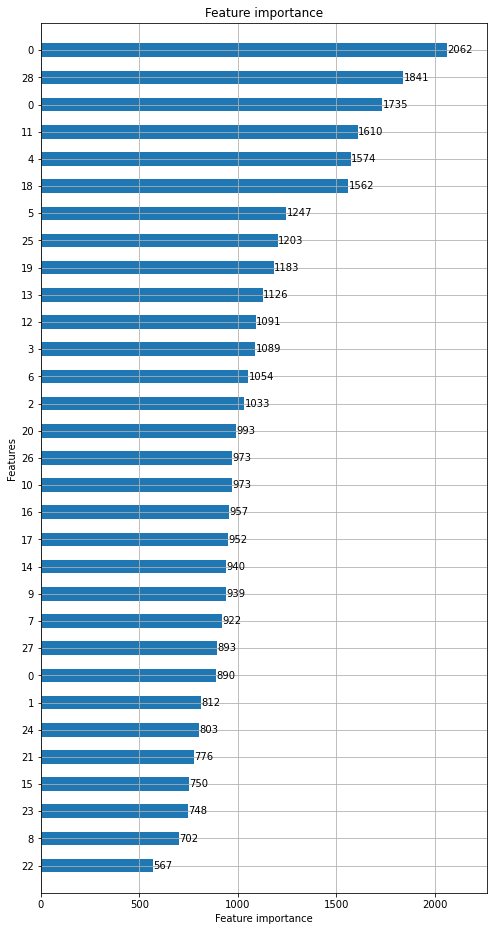

In [13]:
# Save Results -------------------------------------------------------------------------
best_trial_num = np.argmax(lgb_scores)

np.savetxt('Y_val_smx.txt', Y_val_smx[:][best_trial_num])
param_names = lgb_best_params[list(map(len, lgb_best_params)).index(max(list(map(len, lgb_best_params))))].keys()
best_params_dict = lgb_best_params[best_trial_num]
pkl_saver(lgb_best_params, 'best_params_list.csv')
pkl_saver(lgb_best_params, 'best_params.csv')
best_params_dict = pkl_loader('best_params.csv')

# Save CV_Result to csv -------------------------------------------------

results = [Y_val_files[best_trial_num], Y_val_obs[best_trial_num], Y_val_pred[best_trial_num], Y_val_smx[:][best_trial_num]]
pkl_saver(results, './results/results.pkl')
# make_df(val_files)
results_csv = np.concatenate([make_df(Y_val_files[best_trial_num]),make_df(Y_val_obs[best_trial_num]), make_df(Y_val_pred[best_trial_num]), make_df(Y_val_smx[:][best_trial_num])], 1)
results_csv = pd.DataFrame(results_csv)
columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
results_csv.columns=columns
results_csv.to_csv('./results/results_val.csv')
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']

res_smr = classification_report(list(results_csv['obs'].astype(int)), list(results_csv['pred']), target_names = labels, labels = np.array(range(len(labels))))
with open('./results/result_summary_val.txt','w') as f:
    f.write(res_smr)

# Best Model Training -----------------------------------------------
best_model = LGBMClassifier(**lgb_best_params[best_trial_num])
best_model.fit(X_train, Y_train)

columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
results_csv.columns=columns
results_csv.to_csv('./results/results_test.csv')
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
cf_metr = confusion_matrix(Y_test.astype(int).values, best_model.predict(X_test).astype(int))
cf_metr = pd.DataFrame(cf_metr)
cf_metr.columns=labels
cf_metr.index=labels
cf_metr.to_csv("./results/confusion_matrix_test.csv")

# ugokanaikamo 
LGB.plot_importance(best_model, height = 0.5, figsize = (8,16))
plt.savefig('./figure.png')

# Save Model -----------------------------------
pickle.dump(best_model, open("./best_model.pkl", 'wb'))

# Save Code
import shutil
os.mkdir("./code")
code_name = ipynb_path.get().split("/")[-1]
shutil.copy(ipynb_path.get(), f"./code/{code_name}")

In [14]:
read_model = pickle.load(open('./best_model.pkl', 'rb'))

In [15]:
# Show Accuracy --------------------------------------------------------------------------
acc = round(np.array(read_model.predict(X_test).astype(int) == Y_test.astype(int)[0].values).sum() / len(Y_test), 3)*100
print(acc)
if CV_type == "random":
    pkl_saver(acc, f'randomCV_acc_{acc}.txt')
elif CV_type == "sparse":
    pkl_saver(acc, f'spartialCV_acc_{acc}.txt')

66.3


In [ ]:
file_time_name = "2020_1209_1909"
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}")
read_model = pickle.load(open('./best_model.pkl', 'rb'))

In [ ]:
# SAVING OBS but PRED VISUALIZATIONS ------------------------------------
pred = read_model.predict(X_test).astype(int)
obs = Y_test.astype(int)[0].values
lon, lat = [], []
for i in range(len(Y_files)):
    lon.append(float(Y_files.values[i][0].split("_")[1]))
    lat.append(float(Y_files.values[i][0].split("_")[2]))
os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization", exist_ok=True)
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization")
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']

df_lon = make_df(lon)
df_lat = make_df(lat)
df_pred = make_df(pred)
df_obs = make_df(obs)
results = pd.concat([df_lon, df_lat, df_pred, df_obs], axis=1)
results.columns = ["lon", "lat", "pred", "obs"]

os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/csv", exist_ok=True)
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/csv")
results[results["pred"]!=results["obs"]].to_csv("./miss_all.csv")
for i in range(10):
    obs_lis = results[results["pred"]!=results["obs"]][results["obs"]==i]
    pred_lis = results[results["pred"]!=results["obs"]][results["pred"]==i]
    obs_lis.to_csv(f"./obs_{i}.csv")
    pred_lis.to_csv(f"./pred_{i}.csv")


os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_point_check", exist_ok=True)
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_point_check")
for i in range(10):
    obs_lis = results[results["pred"]!=results["obs"]][results["obs"]==i]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for j in range(10):
        pred_j = results[results["pred"]!=results["obs"]][results["obs"]==i][results["pred"]==j]
        if len(pred_j)==0: continue
        ax.set_title(f'OBS = {labels[i]}')
        ax.scatter(pred_j["lon"].values.astype(np.float64), pred_j["lat"].values.astype(np.float64), label=labels[j], s=10)
        ax.set_xlim([120, 155])
        ax.set_ylim([20, 50])
        
        ax.legend(loc='upper left')
        plt.savefig(f"./obs_{labels[i]}.png")


plt.show()

In [ ]:
np.unique(pred)

In [ ]:
pred = read_model.predict(X_test).astype(int)
obs = Y_test.astype(int)[0].values
lon, lat = [], []
for i in range(len(Y_files)):
    lon.append(float(Y_files.values[i][0].split("_")[1]))
    lat.append(float(Y_files.values[i][0].split("_")[2]))

df_lon = make_df(lon)
df_lat = make_df(lat)
df_pred = make_df(pred)
df_obs = make_df(obs)
results = pd.concat([df_lon, df_lat, df_pred, df_obs], axis=1)
results.columns = ["lon", "lat", "pred", "obs"]

In [ ]:
# MISS BAND CHECK --------------------------------
band = 4
for band in range(7):
    DE_check = make_df(X_test).iloc[:,band::7]
    make_df(DE_check)
    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check", exist_ok=True)
    os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check")

    # 1-index
    seasons = ["Summer", "Spring", "Autumn", "Winter"]
    seasons.sort()
    for i in range(10):
        os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/obs_{labels[i]}", exist_ok=True)
        obs_true_lis = make_df(DE_check.to_numpy()[(results["pred"]==results["obs"]) * (results["obs"]==i)])
        obs_miss_lis = make_df(DE_check.to_numpy()[(results["pred"]!=results["obs"]) * (results["obs"]==i)])
    #     for j in range(4):
    #         fig = plt.figure()
    #         ax = fig.add_subplot(1,1,1)
    #         ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_BAND5")
    #         ax.hist(obs_true_lis.iloc[:, j].values, label="TRUE", color="g", alpha=0.3, range=(-2000, 12000), bins=28)

    #         ax.hist(obs_miss_lis.iloc[:, j].values, label="MISS", color="r", alpha=0.3, range=(-2000, 12000), bins=28)
    #         ax.set_xlim([-2000, 12000])
    #         ax.set_ylim([0, 200])
    #         ax.axvline(0, ls = "--", color = "navy")
    #         ax.legend(loc='upper left')
    #         plt.savefig(f"./obs_{labels[i]}/{seasons[j]}_band_5.png")

        upper = 0
        lower = 3000
        
        if i==6:
            look = 7
            aaa = make_df(DE_check.to_numpy()[(results["obs"]==look)])
            bbb = make_df(DE_check.to_numpy()[(results["obs"]==i) * (results["pred"]==look)])
            for j in range(4):
                fig = plt.figure()
                ax = fig.add_subplot(1,1,1)
                fig.patch.set_facecolor('white')  # 図全体の背景色
                fig.patch.set_alpha(0)  # 図全体の背景透明度
                ax.patch.set_facecolor('white')  # subplotの背景色
                ax.patch.set_alpha(0)  # subplotの背景透明度
                #一緒obs=pred
#                 ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_BAND{band+1}")
                ax.hist(obs_true_lis.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[i]}", color="g", alpha=0.5, range=(lower, upper), bins=30)

                #一緒obs=pred
                ax.hist(aaa.iloc[:, j].values, label=f"OBS_{labels[look]}_PRED_{labels[look]}", color="r", alpha=0.3, range=(lower, upper), bins=30)
                ax.set_xlim([lower, upper])
                ax.set_ylim([0, 200])
#                 ax.axvline(0, ls = "--", color = "navy")
#                 ax.legend(loc='upper left')

                #違うobs!=pred
                ax.hist(bbb.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[look]}", color="b", alpha=0.4, range=(lower, upper), bins=30)
                ax.set_xlim([lower, upper])
                ax.set_ylim([0, 200])
#                 ax.axvline(0, ls = "--", color = "navy")
#                 ax.legend(loc='upper left')

                os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/{labels[i]}_and_{labels[look]}", exist_ok=True)
                plt.savefig(f"./{labels[i]}_and_{labels[look]}/{seasons[j]}_band{band+1}.png")


In [ ]:
# MISS BAND CHECK --------------------------------
for band in range(7):
    DE_check = make_df(X_test).iloc[:,band::7]
    make_df(DE_check)
    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check", exist_ok=True)
    os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check")

    # 1-index
    seasons = ["Summer", "Spring", "Autumn", "Winter"]
    seasons.sort()
    
    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/obs_{labels[i]}", exist_ok=True)
    obs_true_dbf = make_df(DE_check.to_numpy()[(results["pred"]==results["obs"]) * (results["obs"]==5)])
    obs_miss_dbf = make_df(DE_check.to_numpy()[(results["pred"]!=results["obs"]) * (results["obs"]==5)])

    look = 1
    aaa = make_df(DE_check.to_numpy()[(results["obs"]==look)])
    bbb = make_df(DE_check.to_numpy()[(results["obs"]==i) * (results["pred"]==look)])
    for j in range(4):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        #一緒obs=pred
        ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_BAND{band+1}")
        ax.hist([obs_true_lis.iloc[:, j], .values, label=f"OBS_{labels[i]}_PRED_{labels[i]}", color="g", alpha=0.5, range=(-2000, 12000), bins=28)

        #一緒obs=pred
        ax.hist(aaa.iloc[:, j].values, label=f"OBS_{labels[look]}_PRED_{labels[look]}", color="r", alpha=0.3, range=(-2000, 12000), bins=28)
        ax.set_xlim([-2000, 12000])
        ax.set_ylim([0, 200])
        ax.axvline(0, ls = "--", color = "navy")
        ax.legend(loc='upper left')

        #違うobs!=pred
        ax.hist(bbb.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[look]}", color="b", alpha=0.4, range=(-2000, 12000), bins=28)
        ax.set_xlim([-2000, 12000])
        ax.set_ylim([0, 200])
        ax.axvline(0, ls = "--", color = "navy")
        ax.legend(loc='upper left')

#                 os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/{labels[i]}_and_{labels[look]}", exist_ok=True)
#                 plt.savefig(f"./{labels[i]}_and_{labels[look]}/{seasons[j]}_band{band+1}.png")


In [ ]:
acc = round(np.array(read_model.predict(X_train).astype(int) == Y_train.astype(int)[0].values).sum() / len(Y_train), 3)*100

In [ ]:
acc

## LightGBM + DEM (1x1 pixel)

In [ ]:
# Data Loader ------------------------------------------------------------------------
N=1
standarization = ["normalization", "Zscore", "normal", "dem"] # pklを作るまではCodeの書き換えも必要だよ！
standarization_num= 3

##### Data Loader ------------------------------
if under==20:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_old/{N}x{N}"
elif under==90:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_new/{N}x{N}"

testfiles = glob(f"D:/LULC/features/01_landsat8/train_new/{N}x{N}_test" + "/*.tif")
testfiles.sort()

root_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/"
result_path    = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/{N}x{N}"
data_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/data/"
model_path     = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/model/{N}x{N}/"
imgfiles = glob(train_tif_name + "/*.tif")
imgfiles.sort()
train_dem_files = glob(os.path.join(f"D:/LULC/features/01_landsat8/train_new/{N}x{N}_dem", "*"))
test_dem_files = glob(os.path.join(f"D:/LULC/features/01_landsat8/train_new/{N}x{N}_test_dem", "*"))
train_dem_files.sort()
test_dem_files.sort()
model_trained = False

# data import ---------------------------------------------------------------------------
timename       = '{0:%Y_%m%d_%H%M}_dem'.format(datetime.datetime.now())
time_path      =  os.path.join(result_path, lgb_boosting_type, timename, "outer_cv_times")
make_dirs(lgb_boosting_type)

X_files, X_train, Y_train, train_point, region_train = train_dem_import()
X_train = X_train.astype(np.float64)
Y_train = Y_train.astype(np.float64)

Y_files, X_test, Y_test, test_point, region_test = test_dem_import()
X_test = X_test.astype(np.float64)
Y_test = Y_test.astype(np.float64) - 1


# # Data converter ----------------------------------------------
X_train = make_df(X_train)
Y_train = make_df(Y_train)
X_test =  make_df(X_test)
Y_test = make_df(Y_test)

In [ ]:
# REMOVE datalack of train and test
del_index = []
for i in range(len(X_train)):
    if sum(X_train.loc[i]==0)>7:
        del_index.append(i)
train_files.drop(index=del_index, inplace=True)
X_train.drop(index=del_index, inplace=True)
Y_train.drop(index=del_index, inplace=True)

del_index = []
for i in range(len(X_test)):
    if sum(X_test.loc[i]==0)>7:
        del_index.append(i)
test_files.drop(index=del_index, inplace=True)
X_test.drop(index=del_index, inplace=True)
Y_test.drop(index=del_index, inplace=True)

In [ ]:
# import data_shape check --------------------------------------------------------
print("X_train: ", type(X_train), X_train.shape)
print("Y_train: ", type(Y_train), Y_train.shape)
print("X_test: ", type(X_test), X_test.shape)
print("Y_test: ", type(Y_test), Y_test.shape)

In [ ]:
# del Y_val_files, lgb_scores, lgb_best_params,  Y_val_smx, Y_val_pred, Y_val_obs

In [ ]:
# train start -----------------------------------------------------------------------------
train_start = datetime.datetime.now()

for outer_cv in range(outer_cvs):
    outer_start = datetime.datetime.now()
    print(f'outer_cv_{outer_cv}_processing....')
    # Data Loader-------------------------------------
    train_files, val_files, X_outer_train, X_outer_val, Y_outer_train, Y_outer_val, val_train_region, val_train_point = lgb_splitter_cv(X_files, X_train, Y_train, outer_cv, region_train, train_point)
    val_train_region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(val_train_point).labels_    
    
    study = optuna.create_study(direction='maximize')
    study.optimize(opt_lgb, n_trials=n_trials)
#     print(study.best_value)
    
    lgb_best_param = study.best_params
    lgb_best = LGBMClassifier(**lgb_best_param)
    lgb_best.fit(X_outer_train, Y_outer_train)
    
    print('mean of outer_val_scores is ', (np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val) ) )
    print('mean of test_scores is ',      (np.array(lgb_best.predict(X_test).astype(int)      == Y_test.astype(int)[0].values).sum() / len(Y_test) ) )
    #     print(lgb_best.predict_proba(X_outer_val).argmax(axis=1))
    
    try:
        Y_val_files.append(val_files)
    except:
        Y_val_files =  [val_files]    
    try:
        lgb_scores.append(np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val))
    except:
        lgb_scores = [np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val)]
    try:
        lgb_best_params.append(lgb_best_param)
    except:
        lgb_best_params = [lgb_best_param]
    try:
        Y_val_smx.append(np.array(lgb_best.predict_proba(X_outer_val)))
    except:
        Y_val_smx = [np.array(lgb_best.predict_proba(X_outer_val))]
    try:
        Y_val_pred.append(lgb_best.predict(X_outer_val).astype(int))
    except:
        Y_val_pred = [lgb_best.predict(X_outer_val).astype(int)]
    try:
        Y_val_obs.append(Y_outer_val[0].values.astype(int))
    except:
        Y_val_obs =  [Y_outer_val[0].values.astype(int)]

    outer_end = datetime.datetime.now()
    spend_time = f"Outer_cv time is {outer_end - outer_start} seconds."
    pkl_saver(spend_time, os.path.join(time_path, f"outer_cv_{outer_cv}_time.txt"))

train_end = datetime.datetime.now()
spend_time = f"Outer_cv time is {train_end - train_start} seconds."
pkl_saver(spend_time, os.path.join(time_path, "all_time.txt"))

In [ ]:
np.unique(lgb_best.predict(X_test).astype(int)), np.unique(Y_test.astype(int)[0].values)

In [ ]:
# Save Results -------------------------------------------------------------------------
best_trial_num = np.argmax(lgb_scores)

np.savetxt('Y_val_smx.txt', Y_val_smx[:][best_trial_num])
param_names = lgb_best_params[list(map(len, lgb_best_params)).index(max(list(map(len, lgb_best_params))))].keys()
best_params_dict = lgb_best_params[best_trial_num]
pkl_saver(lgb_best_params, 'best_params_list.csv')
pkl_saver(lgb_best_params, 'best_params.csv')
best_params_dict = pkl_loader('best_params.csv')

# Save CV_Result to csv -------------------------------------------------

results = [Y_val_files[best_trial_num], Y_val_obs[best_trial_num], Y_val_pred[best_trial_num], Y_val_smx[:][best_trial_num]]
pkl_saver(results, './results/results.pkl')
make_df(val_files)
results_csv = np.concatenate([make_df(Y_val_files[best_trial_num]),make_df(Y_val_obs[best_trial_num]), make_df(Y_val_pred[best_trial_num]), make_df(Y_val_smx[:][best_trial_num])], 1)
results_csv = pd.DataFrame(results_csv)
columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
results_csv.columns=columns
results_csv.to_csv('./results/results_val.csv')
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
# cf_metr = confusion_matrix(Y_val_obs[best_trial_num].astype(int), Y_val_pred[best_trial_num])
# cf_metr = pd.DataFrame(cf_metr)
# cf_metr.columns=labels
# cf_metr.index=labels
# cf_metr.to_csv("./results/confusion_matrix_val.csv")

res_smr = classification_report(list(results_csv['obs'].astype(int)), list(results_csv['pred']), target_names = labels, labels = np.array(range(len(labels))))
with open('./results/result_summary_val.txt','w') as f:
    f.write(res_smr)

# Best Model Training -----------------------------------------------
best_model = LGBMClassifier(**lgb_best_params[best_trial_num])
best_model.fit(X_train, Y_train)

columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
results_csv.columns=columns
results_csv.to_csv('./results/results_test.csv')
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
cf_metr = confusion_matrix(Y_test.astype(int).values, best_model.predict(X_test).astype(int))
cf_metr = pd.DataFrame(cf_metr)
cf_metr.columns=labels
cf_metr.index=labels
cf_metr.to_csv("./results/confusion_matrix_test.csv")

# ugokanaikamo 
LGB.plot_importance(best_model, height = 0.5, figsize = (8,16))
plt.savefig('./figure.png')

# Save Model -----------------------------------
# best_model.save('./model/best_model.hdf5')
# model_trained = True

# Save Code
import shutil
os.mkdir("./code")
code_name = ipynb_path.get().split("/")[-1]
shutil.copy(ipynb_path.get(), f"./code/{code_name}")

In [ ]:
# Show Accuracy --------------------------------------------------------------------------
acc = round(np.array(best_model.predict(X_test).astype(int) == Y_test.astype(int)[0].values).sum() / len(Y_test), 3)*100
print(acc)
pkl_saver(acc, f'acc_{acc}.txt')

## LightGBM (3x3 pixels)

In [ ]:
# Data Loader ------------------------------------------------------------------------
N=3
standarization = ["normalization", "Zscore", "normal"] # pklを作るまではCodeの書き換えも必要だよ！
standarization_num= 2

##### Data Loader ------------------------------
if under==20:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_old/{N}x{N}"
elif under==90:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_new/{N}x{N}"

testfiles = glob(f"D:/LULC/features/01_landsat8/train_new/{N}x{N}_test" + "/*.tif")
testfiles.sort()
root_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/"
result_path    = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/{N}x{N}"
data_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/data/"
model_path     = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/model/{N}x{N}/"
imgfiles = glob(train_tif_name + "/*.tif")
imgfiles.sort()
model_trained = False

# data import ---------------------------------------------------------------------------
timename       = '{0:%Y_%m%d_%H%M}'.format(datetime.datetime.now())
time_path      =  os.path.join(result_path, lgb_boosting_type, timename, "outer_cv_times")
make_dirs(lgb_boosting_type)

X_files, X_train, Y_train, train_point, region_train = train_import()
X_train = X_train.astype(np.float64)

if os.path.exists(data_path + f'df_{N}x{N}_{standarization[standarization_num]}.pkl'):
    df_train = pkl_loader(data_path + f'df_{N}x{N}_{standarization[standarization_num]}.pkl')
else:
    X_train_zeros = np.zeros((X_train.shape[0], N*N*28))
    for i in range(len(X_train)):
        for k in range(3):
            for l in range(3):
                for j in range(28):
                    X_train_zeros[i][j+k+l] = X_train[i][k][l][j]
    X_train = X_train_zeros
    df_train = pd.concat([make_df(Y_train), make_df(X_train)], axis=1)
    pkl_saver(df_train, os.path.join(data_path, f'df_{N}x{N}_{standarization[standarization_num]}.pkl'))
    

Y_files, X_test, Y_test, test_point, region_test = test_import()
X_test = X_test.astype(np.float64)
if os.path.exists(data_path + f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl'):
    df_test = pkl_loader(data_path + f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl')
else:
    X_test_zeros = np.zeros((X_test.shape[0], N*N*28))
    for i in range(len(X_test)):
        for k in range(3):
            for l in range(3):
                for j in range(28):
                    X_test_zeros[i][j+k+l] = X_test[i][k][l][j]
    X_test = X_test_zeros
    df_test = pd.concat([make_df(Y_test), make_df(X_test)], axis=1)
    pkl_saver(df_test, os.path.join(data_path, f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl'))

# Data converter ----------------------------------------------
X_train = df_train.iloc[:, 1:]
Y_train = make_df(Y_train)
X_test =  df_test.iloc[:, 1:]
Y_test = make_df(Y_test)

In [ ]:
# import data_shape check --------------------------------------------------------
print("X_train: ", type(X_train), X_train.shape)
print("Y_train: ", type(Y_train), Y_train.shape)
print("X_test: ", type(X_test), X_test.shape)
print("Y_test: ", type(Y_test), Y_test.shape)

In [ ]:
# del Y_val_files, lgb_scores, lgb_best_params,  Y_val_smx, Y_val_pred, Y_val_obs

In [ ]:
# train start -----------------------------------------------------------------------------
train_start = datetime.datetime.now()

for outer_cv in range(outer_cvs):
    outer_start = datetime.datetime.now()
    print(f'outer_cv_{outer_cv}_processing....')
    # Data Loader-------------------------------------
    train_files, val_files, X_outer_train, X_outer_val, Y_outer_train, Y_outer_val, val_train_region, val_train_point = lgb_splitter_cv(X_files, X_train, Y_train, outer_cv, region_train, train_point)
    val_train_region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(val_train_point).labels_    
    
    study = optuna.create_study(direction='maximize')
    study.optimize(opt_lgb, n_trials=n_trials)
#     print(study.best_value)
    
    lgb_best_param = study.best_params
    lgb_best = LGBMClassifier(**lgb_best_param)
    lgb_best.fit(X_outer_train, Y_outer_train)
    
    print('mean of outer_val_scores is ', (np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val) ) )
    print('mean of test_scores is ',      (np.array(lgb_best.predict(X_test).astype(int)      == Y_test.astype(int)[0].values).sum() / len(Y_test) ) )
    #     print(lgb_best.predict_proba(X_outer_val).argmax(axis=1))
    
    try:
        Y_val_files.append(val_files)
    except:
        Y_val_files =  [val_files]    
    try:
        lgb_scores.append(np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val))
    except:
        lgb_scores = [np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val)]
    try:
        lgb_best_params.append(lgb_best_param)
    except:
        lgb_best_params = [lgb_best_param]
    try:
        Y_val_smx.append(np.array(lgb_best.predict_proba(X_outer_val)))
    except:
        Y_val_smx = [np.array(lgb_best.predict_proba(X_outer_val))]
    try:
        Y_val_pred.append(lgb_best.predict(X_outer_val).astype(int))
    except:
        Y_val_pred = [lgb_best.predict(X_outer_val).astype(int)]
    try:
        Y_val_obs.append(Y_outer_val[0].values.astype(int))
    except:
        Y_val_obs =  [Y_outer_val[0].values.astype(int)]

    outer_end = datetime.datetime.now()
    spend_time = f"Outer_cv time is {outer_end - outer_start} seconds."
    pkl_saver(spend_time, os.path.join(time_path, f"outer_cv_{outer_cv}_time.txt"))

train_end = datetime.datetime.now()
spend_time = f"Outer_cv time is {train_end - train_start} seconds."
pkl_saver(spend_time, os.path.join(time_path, "all_time.txt"))

In [ ]:
# Save Results -------------------------------------------------------------------------
best_trial_num = np.argmax(lgb_scores)

np.savetxt('Y_val_smx.txt', Y_val_smx[:][best_trial_num])
param_names = lgb_best_params[list(map(len, lgb_best_params)).index(max(list(map(len, lgb_best_params))))].keys()
best_params_dict = lgb_best_params[best_trial_num]
pkl_saver(lgb_best_params, 'best_params_list.csv')
pkl_saver(lgb_best_params, 'best_params.csv')
best_params_dict = pkl_loader('best_params.csv')

# Save CV_Result to csv -------------------------------------------------

results = [Y_val_files[best_trial_num], Y_val_obs[best_trial_num], Y_val_pred[best_trial_num], Y_val_smx[:][best_trial_num]]
pkl_saver(results, './results/results.pkl')
make_df(val_files)
results_csv = np.concatenate([make_df(Y_val_files[best_trial_num]),make_df(Y_val_obs[best_trial_num]), make_df(Y_val_pred[best_trial_num]), make_df(Y_val_smx[:][best_trial_num])], 1)
results_csv = pd.DataFrame(results_csv)
columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
results_csv.columns=columns
results_csv.to_csv('./results/results_val.csv')
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
# cf_metr = confusion_matrix(Y_val_obs[best_trial_num].astype(int), Y_val_pred[best_trial_num])
# cf_metr = pd.DataFrame(cf_metr)
# cf_metr.columns=labels
# cf_metr.index=labels
# cf_metr.to_csv("./results/confusion_matrix_val.csv")

res_smr = classification_report(list(results_csv['obs'].astype(int)), list(results_csv['pred']), target_names = labels, labels = np.array(range(len(labels))))
with open('./results/result_summary_val.txt','w') as f:
    f.write(res_smr)

# Best Model Training -----------------------------------------------
best_model = LGBMClassifier(**lgb_best_params[best_trial_num])
best_model.fit(X_train, Y_train)

columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
results_csv.columns=columns
results_csv.to_csv('./results/results_test.csv')
labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land']
cf_metr = confusion_matrix(Y_test.astype(int).values, best_model.predict(X_test).astype(int))
cf_metr = pd.DataFrame(cf_metr)
cf_metr.columns=labels
cf_metr.index=labels
cf_metr.to_csv("./results/confusion_matrix_test.csv")

# ugokanaikamo 
LGB.plot_importance(best_model, height = 0.5, figsize = (8,16))
plt.savefig('./figure.png')

# Save Model -----------------------------------
# best_model.save('./model/best_model.hdf5')
# model_trained = True

# Save Code
import shutil
os.mkdir("./code")
code_name = ipynb_path.get().split("/")[-1]
shutil.copy(ipynb_path.get(), f"./code/{code_name}")

In [ ]:
# Show Accuracy --------------------------------------------------------------------------
acc = round(np.array(best_model.predict(X_test).astype(int) == Y_test.astype(int)[0].values).sum() / len(Y_test), 3)*100
print(acc)
pkl_saver(acc, f'acc_{acc}.txt')